<a href="https://colab.research.google.com/github/Rishthegod/Deep-Learning-Options-Strategy/blob/main/Options_Strategy_Generation_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import *
import holidays
import pytz
import matplotlib.ticker as ticker





#Downloading Historical Price Data:
Yahoo finance can give us historic asset prices. So, I will use this to access Google's historical price as an example throughout this first section.

In [64]:
googl_data =  yf.download("GOOGL", start="2023-01-01", end=datetime.now().date()) #get googl data from Jan 1 2023, to the present day.
googl_closing_prices = googl_data["Close"] #get close price
googl_closing_prices

[*********************100%%**********************]  1 of 1 completed


Date
2023-01-03     89.120003
2023-01-04     88.080002
2023-01-05     86.199997
2023-01-06     87.339996
2023-01-09     88.019997
                 ...    
2024-04-24    159.130005
2024-04-25    156.000000
2024-04-26    171.949997
2024-04-29    166.149994
2024-04-30    162.779999
Name: Close, Length: 333, dtype: float64

#Accessing Real-Time Options Data:

Using the options_chain library in yahoo finance, we can extract relevant options data (bid/ask, I.V.) and return it as a pandas dataframe.


In [65]:
def get_option_data(stock_symbol, expiration_date, option_type, strike):
  """ Documentation:
   Retrieves real-time options data for a specific contract.

   Args:
           stock_symbol (str): Ticker symbol of the underlying asset.
           expiration_date (str): Expiry date of the option contract (YYYY-MM-DD format).
           option_type (str): "call" or "put" for the desired option type.
           strike (float): Strike price of the option contract.
  Returns:
           pandas.DataFrame: DataFrame containing retrieved options data.
  """
  stock = yf.Ticker(stock_symbol)
  option_chain = stock.option_chain(expiration_date)
  options = getattr(option_chain, "calls" if option_type.startswith("call") else "puts") #extract either calls or puts
  option_data = options[options["strike"] == strike] #comprehension to create dataframe
  return option_data


def last_working_day():

    """
    Documentation:

    Returns the last completed trading day

    Args:
              None

    Returns:
              date(str): the date of the last market close in 'YYYY-MM-DD'


    """

    # Get the current date
    eastern = pytz.timezone('America/New_York')
    current_date = datetime.now(eastern) #markets operate in New York, so it is easiest to localize there

    #if its a Monday before market close, return the last Friday
    if current_date.weekday() == 0 and current_date.hour < 16:  # Monday and before 4 PM
        last_working_day = current_date - timedelta(days=3)  # Previous Friday
        return str(last_working_day.date())

    # Check if the current date is a weekend (Saturday or Sunday)
    if current_date.weekday() >= 5:  # Saturday or Sunday
        # Find the last Friday (previous working day)
        last_working_day = current_date - timedelta(days=current_date.weekday() - 4)
        return str(last_working_day.date())

    # Check if the current date is a federal holiday
    us_holidays = holidays.UnitedStates()  # Federal holidays for the United States
    if current_date in us_holidays:
        # Find the last working day before the holiday
        last_working_day = current_date - timedelta(days=1)
        while last_working_day.weekday() >= 5 or last_working_day in us_holidays:
            last_working_day -= timedelta(days=1)
        return str(last_working_day.date())

    #if its currently a workday before market close return the previous completed market day
    if current_date.hour < 16:
      last_working_day = current_date - timedelta(days=1)  # Previous day
      return(str(last_working_day.date()))
    # If it's a workday, after market close, return the current date
    return str(current_date.date())

In [66]:
#Example: Retrieve the call option data for GOOGL expiring on January 17 2025, at the strike price $175

googl_call_data = get_option_data( "GOOGL", "2025-01-17", "call", 175)

#Extract specific data points of value: the bid price and Implied volatility

googl_call_bid_price = googl_call_data["bid"]

googl_call_implied_volatility = googl_call_data["impliedVolatility"]

googl_call_data #print out the current options data



,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
26,GOOGL250117C00175000,2024-04-30 19:58:49+00:00,175.0,13.1,0.0,0.0,0.0,0.0,74,0,0.015635,False,REGULAR,USD


#Quantitative Analysis of Options Data


## Feature Engineering

We can extract different categories of features from our dataset:

**Basic Features:**
*   Bid Price
*   Ask Price
*   Option Type (call/put)
*   Implied Volatility
*   Expiration Date (DTE)
*   Strike Price

**Derived Features (Greeks)**
* Delta (Δ)
* Gamma (Γ)
* Theta (Θ)
* Vega (ν)

**Technical Indicators**
* Moving Average
* Bollinger Bands
* Relative Strength Index


These features will be incorporated into the machine learning model, so it has a complete image of the options contract and its interplay with the market.


## Black-Scholes Greeks Calculation

Calculate the Delta (Δ).
* Δ measures the rate of change of the options price with respect to the underlying assets price (per $1).
* Mathematically this as the first derivative of the option price: Δ = ∂V/∂S
* We will be calculating the Δ using the Black-Scholes option pricing model:
 * Delta formula for call options Δ=(ln(S/K)+(r+σ²/2))/σ√t

   * K is the option strike price.
   * N represents the standard normal cumulative distribution function.
   * r is the risk-free interest rate.
   * σ stands for the underlying asset volatility.
   * S is the underlying asset price.
   * t is the time until the option expires.


In [67]:
def calculate_delta(stock_price, strike_price, risk_free_rate, time_to_expiry, implied_volatility):
  """
    Documentation:
    Calculates the delta of an option using the Black-Scholes model.

    Args:
       stock_price (float): Current price of the underlying asset.
       strike_price (float): Strike price of the option contract.
       risk_free_rate (float): Risk-free interest rate.
       time_to_expiry (float): Time to expiry of the option in years.
       implied_volatility (float): Implied volatility of the option.

    Returns:
       float: The calculated delta value.
   """
  delta = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * implied_volatility**2) * time_to_expiry) \
   / (implied_volatility * np.sqrt(time_to_expiry))
  return norm.cdf(delta)

In [68]:
#Example: calculate the delta of the selected GOOGL call option
googl_call_delta = calculate_delta(
   stock_price= googl_closing_prices.loc[last_working_day()],
   strike_price=175,
   risk_free_rate=0.0460, #approx current risk-free rate
   time_to_expiry=(datetime(year=2025, month=1, day=17) - datetime.now()).days / 365,
   implied_volatility=googl_call_data["impliedVolatility"].iloc[0]
)
print(f'Delta of GOOGL call option: {googl_call_delta:.4f}')

Delta of GOOGL call option: 0.0014


Calculate the Gamma (Γ):

* Γ measures the rate of which the delta changes with respect to the underlying asset's price (per $1)
* Mathematically Γ is the second derivative of the option price with respect to the underlying asset price: Γ = ∂²V/∂S²
* We will be calculating the gamma using the Black-Scholes model:
  * Γ=ϕ(Δ1)/Sσ√t
    * Δ=(ln(S/K)+(r+σ²/2))/σ√t
    * K is the option strike price.
   * N represents the standard normal cumulative distribution function.
   * r is the risk-free interest rate.
   * σ stands for the underlying asset volatility.
   * S is the underlying asset price.
   * t is the time until the option expires.



In [69]:
def calculate_gamma(stock_price,strike_price, risk_free_rate,time_to_expiry, implied_volatility):
  """
    Documentation:

    Calculates the gamma of an option using the Black-Scholes model.

    Args:
           stock_price (float): Current price of the underlying asset.
           strike_price (float): Strike price of the option contract.
           risk_free_rate (float): Risk-free interest rate.
           time_to_expiry (float): Time to expiry of the option in years.
           implied_volatility (float): Implied volatility of the option.
    Returns:
           float: The calculated gamma value.
  """
  delta1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * implied_volatility**2) * time_to_expiry) \
   / (implied_volatility * np.sqrt(time_to_expiry))

  delta2 = delta1 - implied_volatility *np.sqrt(time_to_expiry)

  gamma = norm.pdf(delta1) / (stock_price * implied_volatility *np.sqrt(time_to_expiry))

  return gamma


In [70]:
#Example: calculate gamma for GOOGL call option selected

googl_call_gamma = calculate_gamma(
  stock_price= googl_closing_prices.loc[last_working_day()],
  strike_price=175,
  risk_free_rate=0.0460, #approx current risk-free rate
  time_to_expiry=(datetime(year=2025, month=1, day=17) - datetime.now()).days / 365,
  implied_volatility=googl_call_data["impliedVolatility"].iloc[0]
)

print(f'Gamma of GOOGL call option: {googl_call_gamma:.4f}')


Gamma of GOOGL call option: 0.0021


Calculate the Theta (Θ):
* Θ measures the rate of change of an options price concerning changes in time to expiration
* This is also called time decay, as options lose their time premium as they get closer to expiration
* Mathematically Θ is the first derivative of the option price with respect to time: Θ = ∂V/∂t
* We will be calculating the Θ using the Black-Scholes model:
  * 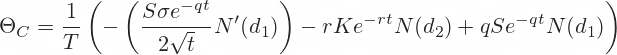
    *  Δ=(ln(S/K)+(r+σ²/2))/σ√t
    * K is the option strike price.
   * N represents the standard normal cumulative distribution function.
   * r is the risk-free interest rate.
   * σ stands for the underlying asset volatility.
   * S is the underlying asset price.
   * t is the time until the option expires.


In [71]:
def calculate_theta(stock_price, strike_price, risk_free_rate,time_to_expiry, implied_volatility):
  """
  Documentation:
  Calculates the theta of an option using the Black-Scholes model.

   Args:
           stock_price (float): Current price of the underlying asset.
           strike_price (float): Strike price of the option contract.
           risk_free_rate (float): Risk-free interest rate.
           time_to_expiry (float): Time to expiry of the option in years.
           implied_volatility (float): Implied volatility of the option.
  Returns:
           float: The calculated theta value.
  """
  delta1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * implied_volatility**2) * time_to_expiry) \
   / (implied_volatility * np.sqrt(time_to_expiry))

  delta2 = delta1 - implied_volatility *np.sqrt(time_to_expiry)

  theta = -(stock_price *norm.pdf(delta1) *implied_volatility) / (2* np.sqrt(time_to_expiry)) \
  - risk_free_rate * strike_price * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(delta2)

  theta = theta /365 # the current formula calculates time decay for the year, but we want it per day, so we divide it 365.

  return theta

In [72]:
#Example: Calculate the theta for the GOOGL call option:

googl_call_theta = calculate_theta(
  stock_price= googl_closing_prices.loc[last_working_day()],
  strike_price=175,
  risk_free_rate=0.046, #approx current risk-free rate
  time_to_expiry=(datetime(year=2025, month=1, day=17) - datetime.now()).days / 365,
  implied_volatility=googl_call_data["impliedVolatility"].iloc[0]
)

print(f'Theta of GOOGL call option { googl_call_theta:.4f}')


Theta of GOOGL call option -0.0000


Calculate Vega (ν):
* ν is the rate of change of an options price with respect to the volatility of the underlying asset
* Mathematically vega is the first derivative of the option price with respect to volatility: ν = ∂V/∂σ
* We will calculate the vega using the Black Scholes model:
  *  v = e
^(−qT) S
√
T φ(d1).
    *  d1 =(ln(S/K)+(r+σ²/2))/σ√t
    * K is the option strike price.
   * N represents the standard normal cumulative distribution function.
   * r is the risk-free interest rate.
   * σ stands for the underlying asset volatility.
   * S is the underlying asset price.
   * t is the time until the option expires.


In [73]:
def calculate_vega(stock_price, strike_price, risk_free_rate,time_to_expiry, implied_volatility):
  """
  Documentation:

  Calculates the vega of an option using the Black-Scholes model.

  Args:
           stock_price (float): Current price of the underlying asset.
           strike_price (float): Strike price of the option contract.
           risk_free_rate (float): Risk-free interest rate.
           time_to_expiry (float): Time to expiry of the option in years.
           implied_volatility (float): Implied volatility of the option.
  Returns:
           float: The calculated vega value.
  """

  delta1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * implied_volatility**2) * time_to_expiry) \
  / (implied_volatility * np.sqrt(time_to_expiry))

  vega = stock_price *norm.pdf(delta1) * np.sqrt(time_to_expiry)

  vega = vega *0.01 #in practical use, we want the vega with respect to a one percent change in interest rate, not a one unit change.

  return vega


In [74]:
#Example: Calculate the vega for the GOOGL call option:

googl_call_vega = calculate_vega(
  stock_price= googl_closing_prices.loc[last_working_day()],
  strike_price=175,
  risk_free_rate=0.046, #approx current risk-free rate
  time_to_expiry=(datetime(year=2025, month=1, day=17) - datetime.now()).days / 365,
  implied_volatility=googl_call_data["impliedVolatility"].iloc[0]
)

print(f'Vega of GOOGL call option { googl_call_vega:.4f}')


Vega of GOOGL call option 0.0062


# Utilizing Deep Learning with Keras

I will be using JPMorgan Chase & Co. as our example to build the deep learning model around and create the optimal options strategy.

This project will focus solely on call options

## Dataset Construction and Structuring


In [75]:
def calculate_options_greeks(row):
  """
  Documentation:

  Calculates all the options greeks defined in the previous section using the Black-Scholes model:

  Args:
          row (Dataframe row): will be an options contract, holding all its related basic features

  Returns:

          delta, gamma, theta, vega (float): the calculated greeks


          Exception case:
          A tuple of np.nan constants with each np.nan corresponding to a greek

  """
  try:
      delta1 = (np.log(row['lastPrice'] / row['strike']) + (0.02 + 0.5 * row['impliedVolatility']**2) * row['time_to_expiry']) \
      / (row['impliedVolatility'] * np.sqrt(row['time_to_expiry'])) #calculate d1

      delta = norm.cdf(delta1) #the actual delta

      gamma = norm.pdf(delta1) / (row['lastPrice'] * row['impliedVolatility'] * np.sqrt(row['time_to_expiry'])) #calculate gamma

      delta2 = delta1 - row['impliedVolatility'] * np.sqrt(row['time_to_expiry']) #calculate d2

      theta = -(row['lastPrice'] * norm.pdf(delta1) * row['impliedVolatility']) / (2 * np.sqrt(row['time_to_expiry'])) \
      - 0.02 * row['strike'] * np.exp(-0.02 * row['time_to_expiry']) * norm.cdf(delta2) #calculate theta

      vega = row['lastPrice'] * norm.pdf(delta1) * np.sqrt(row['time_to_expiry']) #calculate vega

      return delta, gamma, theta, vega



  except Exception as e:

    print(f'Encountered the following error during Greek calculation: {e}')

    raise #re-raise the exception to continue propagating up the call stack

    return np.nan,np.nan,np.nan,np.nan




In [76]:
#Example: Initializing a Ticker Object for the ticker JPM

ticker_symbol = 'JPM' #change this for a different ticker

#Create a yahooFinance ticker object for JPM
jpm_ticker = yf.Ticker(ticker_symbol)

# Get all the availibe/currently listed expiration dates
expiration_dates = jpm_ticker.options

#init an empty dataframe to store the dataset
options_dataset = pd.DataFrame()

In [77]:


#To build the call options dataset, we can iterate over all the expiration dates
for expiration_date in expiration_dates:
  #Fetch the JPM options data for the expiration date currently selected
  jpm_options = jpm_ticker.option_chain(expiration_date)
  #For this project, I will only be using the calls data
  jpm_calls = jpm_options.calls
  #Define a column in the dataframe for expiration_dates
  jpm_calls['expiration_date'] = expiration_date

  #Calculate the "Moneyness"
  ''' Moneyness is the relationship betwen the price of the underlying asset and the strike price:
        Out-of-the-money (OTM): Stock price is below the strike price of the call option
        In-the-Money (ITM): Stock price is above the strike price of the call option
        At-the-Money (ATM): Stock price is equal to strike price, if the option were to expire at that moment, it would have no intrinsic value
  '''

  jpm_calls['Moneyness'] = jpm_calls['lastPrice'] / jpm_calls['strike']

  #Calculate time to expiry in a new column

  jpm_calls['time_to_expiry'] = (pd.to_datetime(expiration_date) - pd.Timestamp.now()).days

  #Using the function defined above, we will calculate the greeks:
  jpm_calls[['delta', 'gamma', 'theta', 'vega']] = jpm_calls.apply(calculate_options_greeks, axis=1, result_type='expand')


  #Append the current option to the overall dataset:
  options_dataset = pd.concat([options_dataset, jpm_calls], ignore_index=True)


#Display a random five option contracts for a feel for the structure of the , sample for the first 100 rows, so we have relatively closer expiring contracts.
options_dataset.head(100).sample(n=5)





,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,expiration_date,Moneyness,time_to_expiry,delta,gamma,theta,vega
80,JPM240517C00207500,2024-04-30 14:36:59+00:00,207.5,0.20,0.0,0.0,0.0,0.0,4.0,0,...,False,REGULAR,USD,2024-05-17,0.000964,15,1.077469e-164,6.088637e-162,-5.185388e-166,2.283581e-163
30,JPM240510C00170000,2024-04-26 16:49:19+00:00,170.0,24.53,0.0,0.0,0.0,0.0,10.0,0,...,True,REGULAR,USD,2024-05-10,0.144294,8,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
0,JPM240503C00155000,2024-04-29 14:36:15+00:00,155.0,39.11,0.0,0.0,0.0,0.0,1.0,0,...,True,REGULAR,USD,2024-05-03,0.252323,1,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
27,JPM240503C00240000,2024-04-19 19:30:16+00:00,240.0,0.01,0.0,0.0,0.0,0.0,1.0,0,...,False,REGULAR,USD,2024-05-03,0.000042,1,2.947422e-88,1.174917e-84,-1.474426e-89,5.874642e-89
61,JPM240517C00145000,2024-04-30 13:52:03+00:00,145.0,49.72,0.0,0.0,0.0,0.0,5.0,0,...,True,REGULAR,USD,2024-05-17,0.342897,15,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00


## Model Development and Training

* Now that we have the dataset of our JPM contracts, we will now focus on building the deep learning model.
* The model will use the greeks, moneyness, volatility, and DTE as features for our model.
* Our target variable will the last price of the option.


In [78]:
#Define the target variable

target_variable = 'lastPrice'

# Create the features list for the model

features = ['strike', 'Moneyness', 'time_to_expiry', 'impliedVolatility', 'delta', 'gamma', 'theta', 'vega']

#Perform data cleaning (getting rid of NaNs)

options_dataset = options_dataset.dropna()

#Create the feature matrix and the target variable

X = options_dataset[features].dropna()

y =options_dataset[target_variable]

#To avoid erroneous model training, we want ot scale the feature values

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

#Split the data into training and testing data sets with split 80/20.

#It is not the best practice to use 42 as our random state, but we will be using it anyways!
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)










In [79]:
#Build our layered neural network model

model = Sequential()

#add a ReLU activation layer
model.add(Dense(128, input_dim = len(features), activation = 'relu'))

#add a dropout layer to avoid overfitting

model.add(Dropout(0.2))

#add another ReLU activation layer
model.add(Dense(64, activation='relu'))

#add another dropout layer to avoid overfitting
model.add(Dropout(0.2))

#linear activation layer
model.add(Dense(1, activation='linear'))

#Compile our model with a MSE loss function, with an Adam optimizer deplpoyed for training
model.compile(optimizer='adam', loss='mean_squared_error')

#Finally, we can train the model:

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
12/12 [==============================] - 1s 17ms/step - loss: 2231.1138 - val_loss: 1787.1071
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 2125.7654 - val_loss: 1689.5459
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 1968.2878 - val_loss: 1530.7943
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 1710.9093 - val_loss: 1288.2026
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 1365.6405 - val_loss: 969.2165
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 924.6908 - val_loss: 606.2994
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 512.1420 - val_loss: 294.9328
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 244.8080 - val_loss: 121.6464
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 127.4496 - val_loss: 80.0512
Epoch 10/50
12/12 [==============================] - 0s 6ms/step - loss: 

## Testing the Model

We are now going to evauluate the model's performance on the testing set

In [80]:
# Run the evaluator on the testing set

mse = model.evaluate(X_test, y_test)




3/3 [==============================] - 0s 4ms/step - loss: 24.0742


In [81]:
#For the testing set, predict options prices:
predictions = model.predict(X_test)


3/3 [==============================] - 0s 4ms/step


In [82]:
#Compare predictions with actual prices

comparison_df = pd.DataFrame({'Actual Price': y_test.values, 'Predicted Price': predictions.flatten()})
#print out a sample of the comparisons

print(f'Mean-Squared-Error on the Testing Set: {mse}')
print(comparison_df.sample(10))

Mean-Squared-Error on the Testing Set: 24.07416343688965
    Actual Price  Predicted Price
78          0.01         0.314854
45          0.41         0.292914
54         69.22        83.639145
69         41.20        38.227596
65         63.20        56.921177
44          0.02        -0.257601
12         12.45        11.504924
92          0.04        -0.319399
61          0.02        -0.630312
49         21.30        21.663166


## Visualizing our results

For this project, I chose to go with matplotlib and seaborn to visualize the results

**Visualizing Training and Validation Loss**

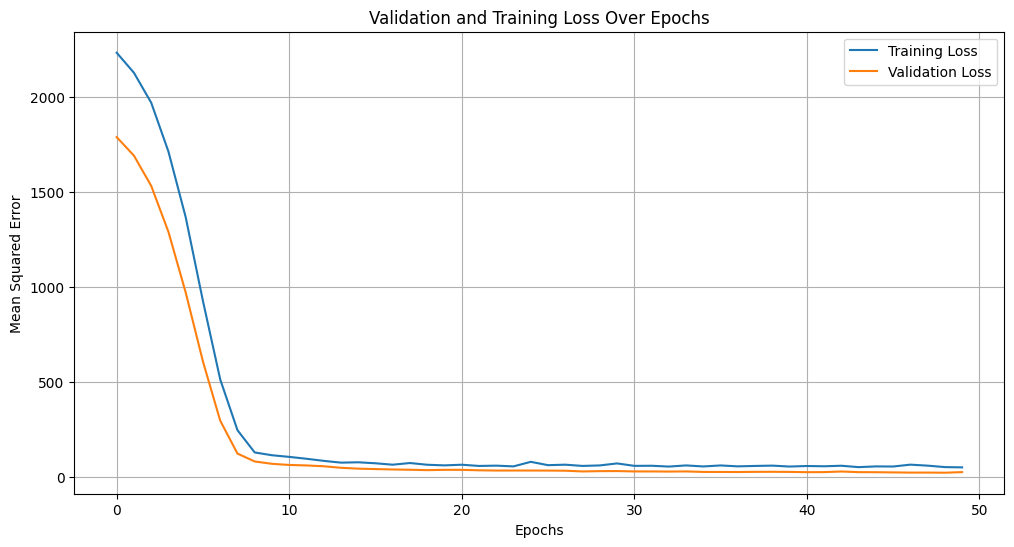

In [83]:
# Visualize both validation and training loss over epochs

plt.figure(figsize = (12, 6))


plt.plot(history.history['loss'], label = 'Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')


plt.title('Validation and Training Loss Over Epochs')

plt.xlabel("Epochs")

plt.ylabel("Mean Squared Error")

plt.legend()

plt.grid(True)

plt.show()



**Visualizing Predicted vs. Actual Prices**
* We are going to now visualize the correlation between predicted and actual option prices on the test set.
* We are going to create a scatter plot of actual prices vs. predictions, the ideal relationship will be shown with a diagonal line.
* The residuals will show the model's predictive error


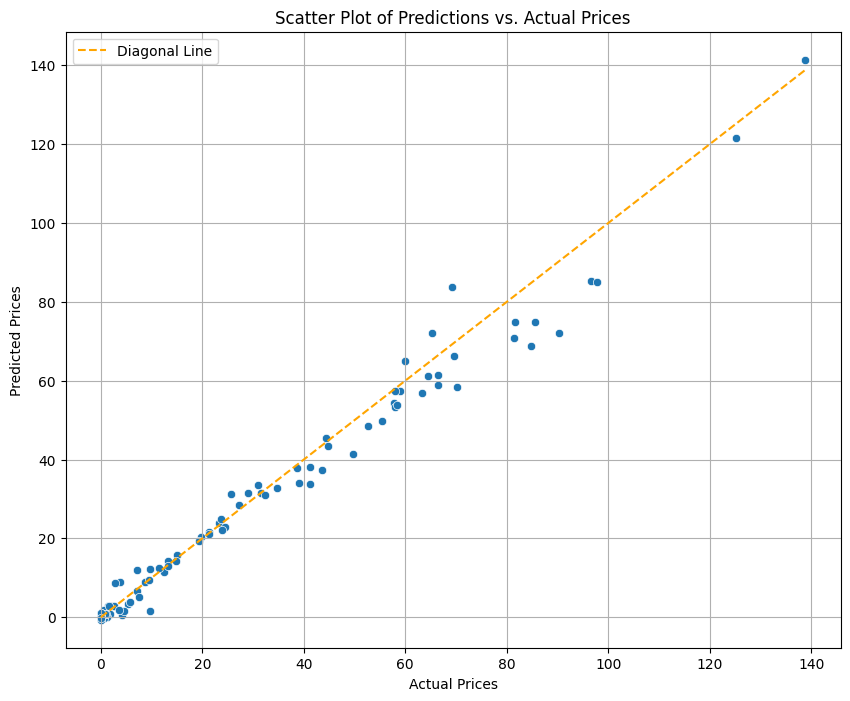

In [84]:

plt.figure(figsize=(10, 8))

sns.scatterplot(x = y_test, y=predictions.flatten())

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='orange', label='Diagonal Line')

plt.title('Scatter Plot of Predictions vs. Actual Prices')

plt.xlabel('Actual Prices')

plt.ylabel('Predicted Prices')

plt.grid(True)

plt.legend()

plt.show()


# Options Strategy Creation and Backtesting

* The Strategy will be based on trade signals created by the Deep Learning model
* The Dataset will be created by zipping together historical JPM prices and the options_dataset
* The Strategy performance will then be asessed

## Formulating the Strategy dataset

In [85]:
#Extract historical close prices for JPM


jpm_prices = jpm_ticker.history(period='1y', interval='1d')['Close']



In [86]:
# Convert the numerical options_dataset indices to datetime format in New York timezone

options_dataset.index = pd.to_datetime(options_dataset.index).tz_localize('America/New_York')

#Match the jpm_prices indices with the options_dataset indices and reindex them

jpm_prices = jpm_prices.reindex(options_dataset.index, method='ffill') #use forward filling to handle any missing values



## Creating the Strategy Signal based on predictions

In [87]:
#Calculate the Strategy returns

'''We will predict the options prices using the trained model and scale the features respectively'''
options_dataset['Predicted_Price'] = model.predict(scaler.transform(options_dataset[features]))

options_dataset['Signal'] = np.where(options_dataset['Predicted_Price'] > options_dataset['lastPrice'], 1, -1) #signal creation

15/15 [==============================] - 0s 2ms/step


**Strategy Outputs:**

* The Strategy will have three possible states:
  * 1 : Buy/Hold the option
    * This will be triggered if the predicted price is higher than the the current option price.
  * -1 : Sell/ Hold Cash
    * This will be triggered if the buy condition is not true.
  * 0 : No change in position
  

In [88]:
#Create an intial position:

options_dataset['Position'] = options_dataset['Signal'].shift(1) #need to prevent look-ahead bias (preventing data leaks)

options_dataset['Position'].fillna(0, inplace = True) #Initial position needs to be 0 (holding cash)



## Calculating Percentage Returns

* This section will be backtesting the strategy based on histroical JPM prices
* We will calculate the Daily and the Aggregated strategy return and represent the overall performance of the strategy


In [89]:
# Risk Management Parameters
risk_per_trade = 0.05  # Maximum risk per trade (3% of total capital)
stop_loss_pct = 0.10  # Stop loss percentage (10% loss from entry price)
volatility_multiplier = 2  # Multiplier for volatility-based position sizing

# Calculate position size based on risk per trade and stop loss percentage
total_capital = 10000  # Example: $10,000
max_loss_per_trade = total_capital * risk_per_trade
options_dataset['Stop_Loss'] = options_dataset['lastPrice'] * (1 - stop_loss_pct)
options_dataset['Position_Size'] = max_loss_per_trade / (options_dataset['lastPrice'] - options_dataset['Stop_Loss'])

# Adjust position size based on volatility
options_dataset['Volatility_Adjustment'] = volatility_multiplier * options_dataset['vega']  # Using Vega as a volatility metric
options_dataset['Position_Size'] *= options_dataset['Volatility_Adjustment']

# Implement stop-loss orders
options_dataset['Stop_Loss_Triggered'] = np.where(options_dataset['lastPrice'] < options_dataset['Stop_Loss'], 1, 0)
options_dataset['Position'] = np.where(options_dataset['Stop_Loss_Triggered'] == 1, 0, options_dataset['Position'])

#Calculate daily percentage returns when the strategy is utilized

options_dataset['Strategy_Return'] = options_dataset['Position'] * options_dataset['lastPrice'].pct_change() #calculate the daily return of the strategy
options_dataset['Cumulative_Strategy_Return'] = (1 + options_dataset['Strategy_Return']).cumprod() - 1 #compute the cumulative strategy return

In [90]:
# We can now take a look at the strategy returns

options_dataset[['lastPrice', 'Predicted_Price', 'Signal', 'Position', 'Position_Size', 'Stop_Loss', 'Strategy_Return', 'Cumulative_Strategy_Return']].tail(1000)


,lastPrice,Predicted_Price,Signal,Position,Position_Size,Stop_Loss,Strategy_Return,Cumulative_Strategy_Return
1970-01-01 00:00:00-05:00,39.11,34.000122,-1,0.0,0.000000e+00,35.199,NaN,NaN
1970-01-01 00:00:00.000000001-05:00,24.40,28.010733,1,-1.0,0.000000e+00,21.960,0.376119,0.376119
1970-01-01 00:00:00.000000002-05:00,33.72,27.437906,-1,1.0,0.000000e+00,30.348,0.381967,0.901751
1970-01-01 00:00:00.000000004-05:00,23.70,22.672314,-1,-1.0,0.000000e+00,21.330,0.297153,1.466862
1970-01-01 00:00:00.000000005-05:00,11.85,18.938541,1,-1.0,0.000000e+00,10.665,0.500000,2.700293
...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000000497-05:00,7.10,6.592290,-1,-1.0,5.034648e-26,6.390,0.252632,-1.000000
1970-01-01 00:00:00.000000498-05:00,5.00,4.999062,-1,-1.0,3.435543e-04,4.500,0.295775,-1.000000
1970-01-01 00:00:00.000000499-05:00,4.54,3.946566,-1,-1.0,5.854470e-04,4.086,0.092000,-1.000000
1970-01-01 00:00:00.000000500-05:00,2.80,3.204273,1,-1.0,4.298430e-03,2.520,0.383260,-1.000000


# Strategy Outcome

**Current Model Signal**

In [91]:
# Get the latest signal for the next trading day
next_day_signal = options_dataset['Signal'].iloc[-1]

# Depending on the signal, take appropriate action
if next_day_signal == 1:
    # Buy the option or hold existing position
    print("Consider buying the corresponding option or holding existing position.")
elif next_day_signal == -1:
    # Sell the option or hold cash
    print("Consider selling the corresponding option or holding cash.")
else:
    # No change in position
    print("No change in position.")


Consider buying the corresponding option or holding existing position.


**Visualizing Strategy Returns in a Simulated Environment**

* Make trades using $10,000 of simulated.
* Buying and Selling are based on signals generated by the strategy
* Return is plotted and total return is calculated

In [92]:
# Function to generate buy/sell signals
def generate_signals(options_dataset):
    options_dataset['Signal'] = np.where(options_dataset['Predicted_Price'] > options_dataset['lastPrice'], 1, -1)

# Function to execute paper trades
def execute_trades(options_dataset, initial_cash):
    cash = initial_cash
    position = 0
    portfolio = []

    for index, row in options_dataset.iterrows():
        if row['Signal'] == 1 and cash >= row['lastPrice']:
            position += 1
            cash -= row['lastPrice']
            portfolio.append(('BUY', index, row['lastPrice']))
        elif row['Signal'] == -1 and position > 0:
            position -= 1
            cash += row['lastPrice']
            portfolio.append(('SELL', index, row['lastPrice']))

    # Calculate final portfolio value
    final_portfolio_value = cash + position * options_dataset.iloc[-1]['lastPrice']

    return portfolio, final_portfolio_value

# Live trading implementation
def live_trading(options_dataset, initial_cash=10000):
    # Generate signals
    generate_signals(options_dataset)

    # Execute paper trades
    portfolio, final_portfolio_value = execute_trades(options_dataset, initial_cash)

    # Calculate cumulative returns
    cumulative_returns = [initial_cash]
    current_cash = initial_cash
    for trade in portfolio:
        if trade[0] == 'BUY':
            current_cash -= trade[2]
        else:
            current_cash += trade[2]
        cumulative_returns.append(current_cash)

    # Plot cumulative returns
    plt.figure(figsize=(12, 8))
    plt.plot(cumulative_returns, marker='o', linestyle='-', color='royalblue')
    plt.title('Cumulative Returns Over Trades', fontsize=16)
    plt.xlabel('Trades', fontsize=14)
    plt.ylabel('Portfolio Value ($)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)



    # Annotate last data point with final portfolio value and total return
    final_point = len(cumulative_returns) - 1
    plt.annotate(f'Final Value: ${cumulative_returns[-1]:,.2f}\nTotal Return: ${(cumulative_returns[-1] - initial_cash):,.2f}\nReturn %: {(((cumulative_returns[-1] - initial_cash)/initial_cash)*100):.2f}%',
                 xy=(final_point, cumulative_returns[-1]),
                 xytext=(-60, 40),
                 textcoords='offset points',
                 fontsize=12,
                 arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5))

    plt.tight_layout()
    sns.despine()
    plt.show()

    return portfolio, final_portfolio_value



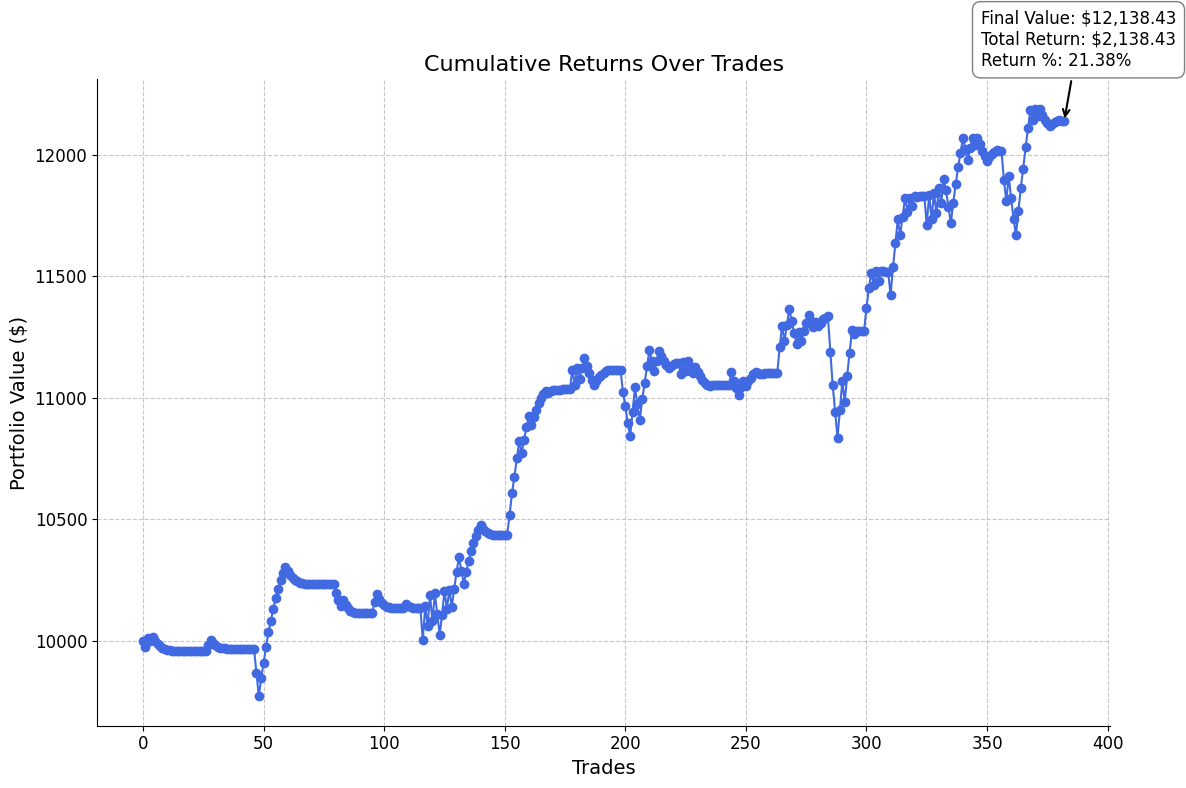

In [93]:
portfolio, final_portfolio_value = live_trading(options_dataset)

